# Regression and Prediction

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

In [4]:
lung = pd.read_csv('../../data/LungDisease.csv')

## Simple Linear regression: 

$$Y = b_0 + b_1 X$$




[]

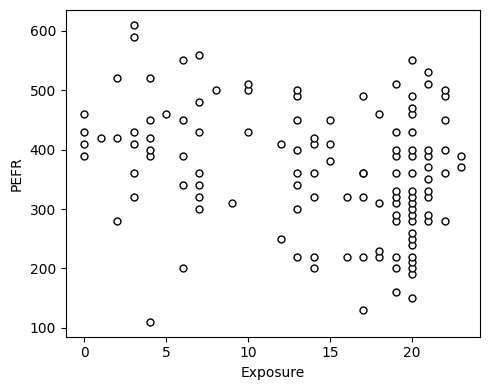

In [19]:
lung.plot.scatter(x='Exposure', y='PEFR', s=25, color='white', edgecolor='black', figsize=(5,4))
plt.tight_layout()
plt.plot()

# in this case, PEFR = b0 + b1 Exposure

In [12]:
features = ['Exposure'] # x values, predictos (for matrix shaped)
target = 'PEFR' # y values, outcome

model = LinearRegression()
model.fit(lung[features], lung[target])

print(f'Intercept: {model.intercept_:.2f}')
print(f'Coefficient Exposure: {model.coef_[0]:.2f}')


Intercept: 424.58
Coefficient Exposure: -4.18


The intercept, or $b_0$, is 424.583 and can be interpreted as the predicted PEFR for a worker with zero years exposure. The regression coefficient, or $b_1$, can be interpreted as follows: for each additional year that a worker is exposed to cotton dust, the worker’s PEFR measurement is reduced by –4.185

[0, 23]

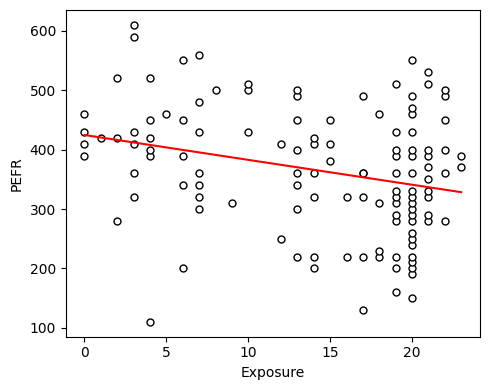

In [32]:
# Create a range of x values
x_range = [lung['Exposure'].min(), lung['Exposure'].max()]

# Calculate the corresponding y values for the line
y_range = model.intercept_ + model.coef_ * x_range

lung.plot.scatter(x='Exposure', y='PEFR', s=25, color='white', edgecolor='black', figsize=(5,4))
plt.plot(x_range, y_range, color='r')
plt.tight_layout()

x_range